In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Resize, InterpolationMode, Lambda
# InterpolationMode.NEAREST

In [ ]:
%pip -q install torchinfo
from torchinfo import summary

In [ ]:
data = MNIST("/tmp/mnist",download=True, transform=Compose((
    ToTensor(),
    Resize((8,8), interpolation=InterpolationMode.BILINEAR)
    )))

In [ ]:
dloader = torch.utils.data.DataLoader(data, batch_size=32)
dloader

In [ ]:
sample, labels = next(iter(dloader))

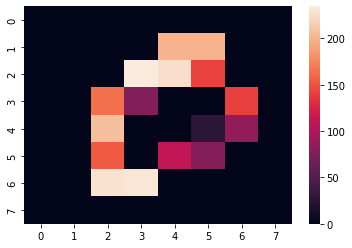

In [ ]:
sns.heatmap(sample[1,0] * 255)
plt.show()

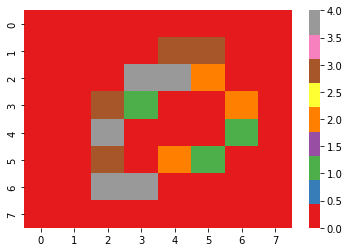

In [ ]:
n_cats = 5
x = np.array(sample[1,0]*n_cats).astype(np.uint8)
sns.heatmap(x, cmap="Set1")
plt.show()

In [ ]:
dist = pd.Series(sample[1,0].numpy().ravel())
dist.describe()

count    64.000000
mean      0.153776
std       0.296636
min       0.000000
25%       0.000000
50%       0.000000
75%       0.025245
max       0.920098
dtype: float64

In [ ]:
# data.

In [ ]:
x = data.data.ravel() / 255.0
np.histogram(x, bins=4)

(array([39682700,  1135869,  1238702,  4982729]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float32))

(array([40818569.,  6221431.]),
 array([0. , 0.5, 1. ], dtype=float32),
 <a list of 2 Patch objects>)

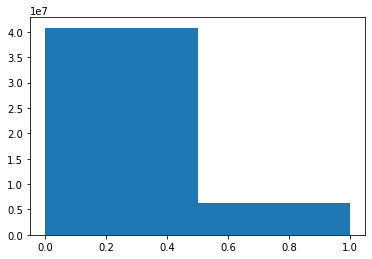

In [ ]:
N_CATEGORIES = 3
_,BINS = np.histogram(x[::4], bins=N_CATEGORIES-1)
plt.hist(x, bins=BINS)

In [ ]:
inds = torch.from_numpy(np.digitize(sample, BINS, right=True))
inds[0,0]

tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 2, 0],
        [0, 0, 2, 2, 2, 0, 0, 0],
        [0, 0, 0, 2, 0, 0, 0, 0],
        [0, 0, 0, 0, 2, 1, 0, 0],
        [0, 0, 0, 1, 2, 2, 0, 0],
        [0, 1, 2, 2, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
torch.bucketize(sample[:1], torch.from_numpy(BINS))

tensor([[[[0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 1, 1, 2, 0],
          [0, 0, 2, 2, 2, 0, 0, 0],
          [0, 0, 0, 2, 0, 0, 0, 0],
          [0, 0, 0, 0, 2, 1, 0, 0],
          [0, 0, 0, 1, 2, 2, 0, 0],
          [0, 1, 2, 2, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0]]]])

tensor(5)

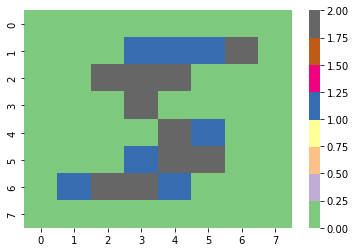

In [ ]:
sns.heatmap(inds[0,0], cmap="Accent")
labels[0]

In [ ]:
def to_1hot(x):
  x = torch.bucketize(x, torch.from_numpy(BINS))
  x = F.one_hot(x, num_classes=N_CATEGORIES)
  x = x.permute(3,1,2,0).squeeze().float()
  return x

TODO: Resize to smaller image

In [ ]:
from torch.utils.data import random_split
data = MNIST("/tmp/mnist",download=True, transform=Compose((
    ToTensor(),
    Resize((8,8), interpolation=InterpolationMode.BILINEAR),
    Lambda(to_1hot)
)))
num_samples = data.data.shape[0]
train_data, val_data = random_split(
    data,[int(0.9*num_samples), int(0.1*num_samples)]
)

train_ds = torch.utils.data.DataLoader(train_data, batch_size=256)

val_ds = torch.utils.data.DataLoader(val_data, batch_size=1024)

In [ ]:
0.9*num_samples

54000.0

In [ ]:
X, y = next(iter(val_ds))
X.shape

torch.Size([1024, 3, 8, 8])

In [ ]:
# net(X.float(), torch.zeros(X.shape[0])).shape

### Do I want scores of 1-hot probailities or logits..?
Latter might help with climbing scores but idk if gradient calulatuon is valid

In [ ]:
np.exp(np.log(2))

2.0

In [ ]:
def to_logit(probs):
  eps = 1e-5
  # x = torch.clamp(probs, min=eps, max=1-eps)
  l = torch.clamp(torch.log(probs), min=np.log(eps))
  return l

def log_concrete_sample(class_logits, tau):
  eps = 1e-20
  U = torch.rand(class_logits.shape, device=class_logits.device)
  gumbel_samples = -torch.log(-torch.log(U+eps)+eps)

  x = (gumbel_samples + class_logits) / tau
  x = x - torch.logsumexp(x, dim=1, keepdim=True)
  return x

def log_concrete_grad(x_logit, class_logits, tau):
  K = class_logits.shape[1]
  logit_noise = class_logits - tau * x_logit
  # sum_exp = torch.sum(torch.exp(logit_noise), dim=1, keepdim=True)
  # grad = -tau + tau * K * torch.exp(logit_noise)/sum_exp

  grad = -tau + tau*K*torch.softmax(logit_noise, dim=1)

  return grad

def gumbel_softmax(class_logits, tau):
  eps = 1e-20
  U = torch.rand(class_logits.shape, device=class_logits.device)
  gumbel_samples = -torch.log(-torch.log(U+eps)+eps)
  x = (gumbel_samples + class_logits) / tau
  return torch.softmax(x, dim=1).contiguous()


def gumbel_grad(x_sample, class_logits, tau, K):
  pis = class_logits.softmax(dim=1).contiguous()
  logit_sum = torch.sum(pis / torch.pow(x_sample, tau),
                        dim=1, keepdim=True
                        )
  denominator = logit_sum * torch.pow(x_sample, tau+1)
  bias = (tau+1)/x_sample

  grad = ((tau * K * pis) / denominator) - bias

  return grad

In [ ]:
x = X[13].clone().unsqueeze(0).repeat(1000,1,1,1)
x.shape

torch.Size([1000, 3, 8, 8])

In [ ]:
y[13]

tensor(6)

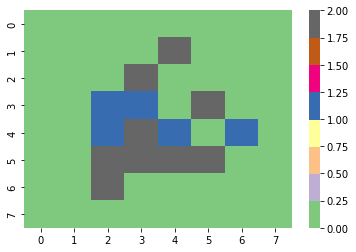

In [ ]:
img = to_logit(x).argmax(dim=1)
sns.heatmap(img[1], cmap="Accent")

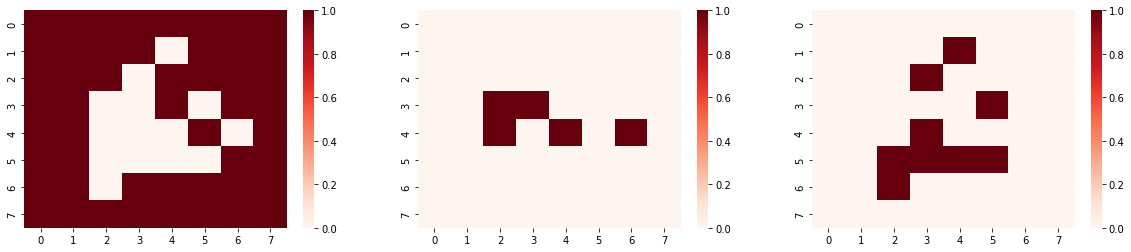

In [ ]:
fig, axs = plt.subplots(1,N_CATEGORIES, figsize=(20,4))
for i in range(N_CATEGORIES):
  sns.heatmap(x[1,i], ax=axs[i], vmax=1.0, cmap="Reds")

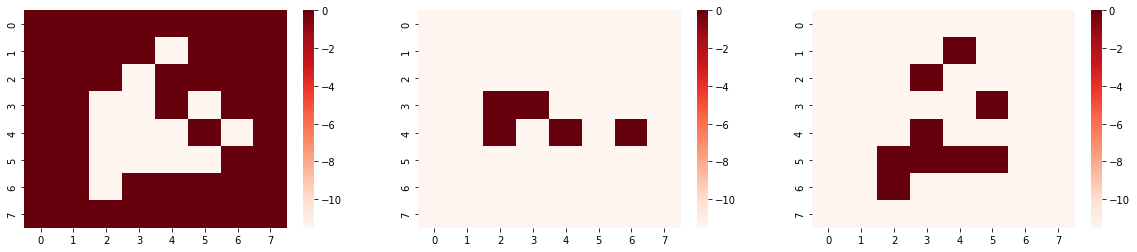

In [ ]:
fig, axs = plt.subplots(1, N_CATEGORIES, figsize=(20,4))
x_logit = to_logit(x)
_x = x_logit.softmax(1)
for i in range(N_CATEGORIES):
  sns.heatmap(x_logit[1,i], ax=axs[i], cmap="Reds")

In [ ]:
# x_logit

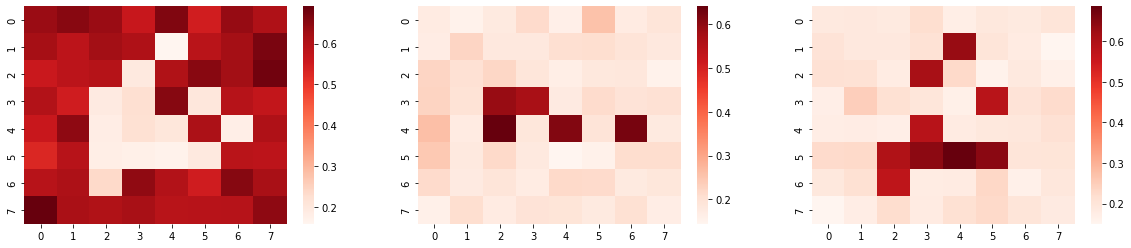

In [ ]:
MAX_TAU=10.0
x_logit = to_logit(x)
x_noisy = log_concrete_sample(x_logit, tau=MAX_TAU)
fig, axs = plt.subplots(1,N_CATEGORIES, figsize=(20,4))
for i in range(x_noisy.shape[1]):
  sns.heatmap(x_noisy[0,i].exp(), ax=axs[i], cmap="Reds")

In [ ]:
torch.logsumexp(x_noisy[0], dim=0).mean()

tensor(-1.3970e-09)

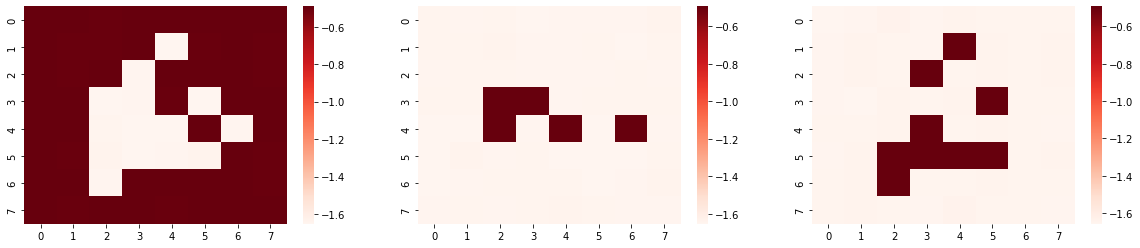

In [ ]:
fig, axs = plt.subplots(1,N_CATEGORIES, figsize=(20,4))
for i in range(x_noisy.shape[1]):
  sns.heatmap(x_noisy[:,i].mean(0), ax=axs[i], cmap="Reds")

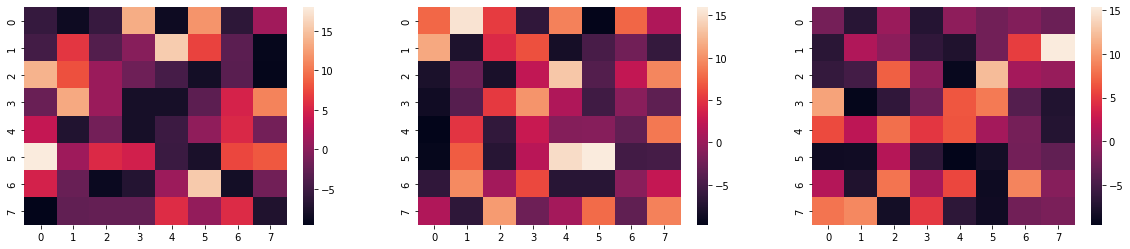

In [ ]:
x_grad = log_concrete_grad(x_noisy, x_logit, tau=MAX_TAU)
fig, axs = plt.subplots(1,N_CATEGORIES, figsize=(20,4))
for i in range(N_CATEGORIES):
  sns.heatmap(x_grad[0][i], ax=axs[i])

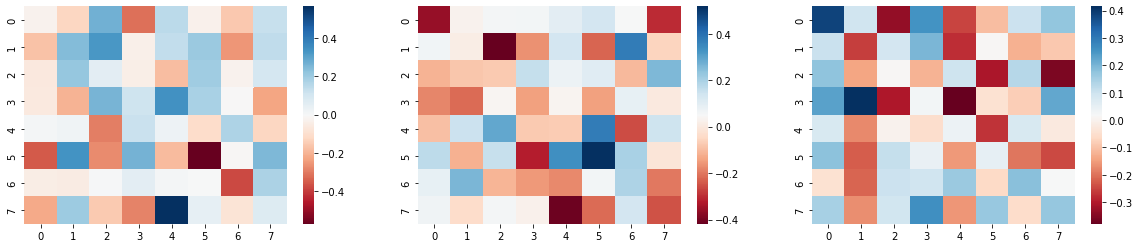

In [ ]:
grad_mean = x_grad.mean(0)
fig, axs = plt.subplots(1,N_CATEGORIES, figsize=(20,4))
for i in range(N_CATEGORIES):
  sns.heatmap(grad_mean[i], ax=axs[i], cmap="RdBu")

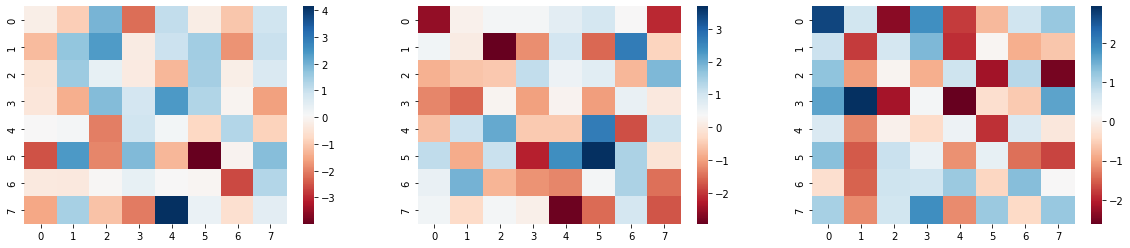

In [ ]:
scaled_grad = (x_grad * x_grad.std(dim=0)).mean(0)
fig, axs = plt.subplots(1, N_CATEGORIES, figsize=(20,4))
for i in range(N_CATEGORIES):
  sns.heatmap(scaled_grad[i], ax=axs[i], cmap="RdBu")

Note that each pixel is an independent "feature" with its own categories.
It just happens to be that every one has 5 categories
Think abouit how you would convert the image into a tabular form
You would have 5*(28*28) features from which you would have to compute gradients on chunks of five.

In [ ]:
x_rec = x_noisy + (x_grad * 1e-1 )
# x_rec = torch.softmax(x_rec, dim=1)
x_rec_mean = x_rec.mean(0)
x_rec_probs = (x_rec - torch.logsumexp(x_rec, dim=1, keepdims=True)).mean(0).exp()
x_noisy_mean = x_noisy.mean(0)
x_rec_mean.shape, x_noisy_mean.shape, x_rec.shape

(torch.Size([3, 8, 8]), torch.Size([3, 8, 8]), torch.Size([1000, 3, 8, 8]))

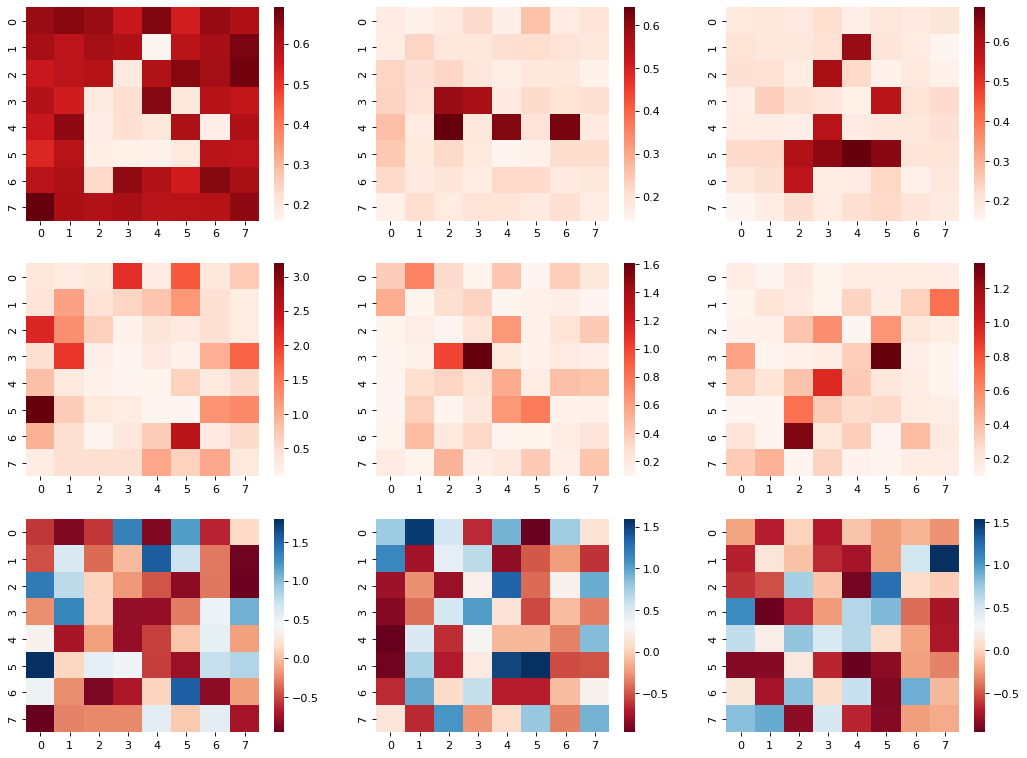

In [ ]:
fig, axs = plt.subplots(3, N_CATEGORIES, figsize=(16,12), dpi=80)
for i in range(N_CATEGORIES):
  sns.heatmap(x_noisy[0].exp()[i], ax=axs[0,i], vmin=None, vmax=None, cmap="Reds")
  sns.heatmap(x_rec[0].exp()[i], ax=axs[1,i], vmax=None, cmap="Reds")
  sns.heatmap((x_rec[0][i]-x_noisy[0][i]), ax=axs[2,i], vmin=None, vmax=None, cmap="RdBu")

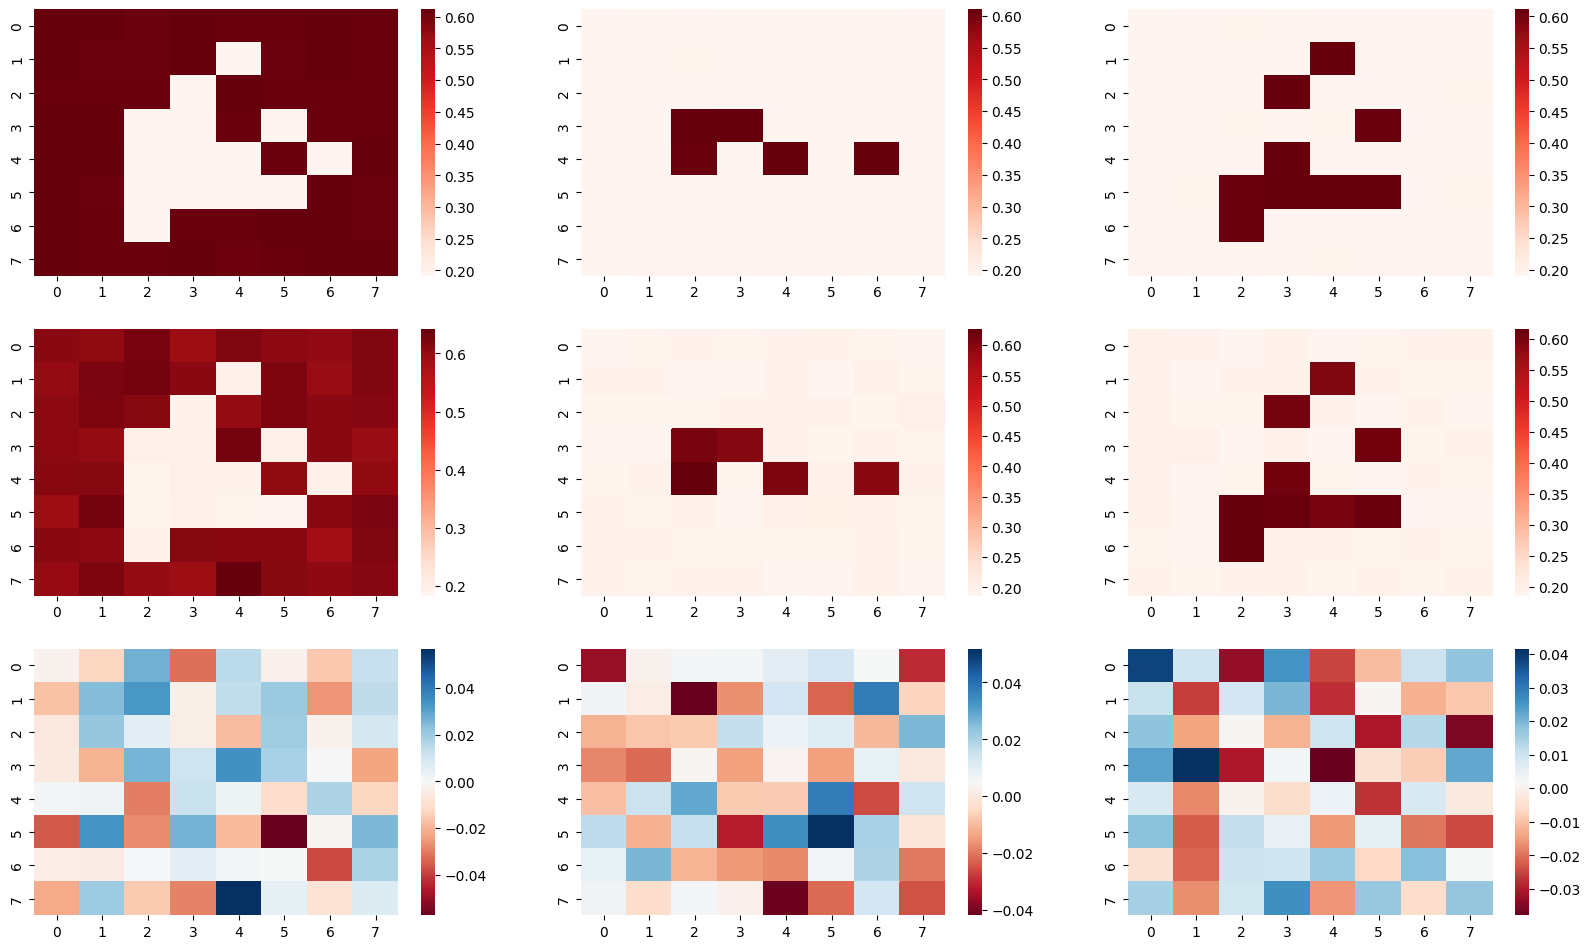

In [ ]:
fig, axs = plt.subplots(3, N_CATEGORIES, figsize=(20,12), dpi=100)
for i in range(N_CATEGORIES):
  sns.heatmap(x_noisy_mean[i].exp(), ax=axs[0,i], vmin=None, vmax=None, cmap="Reds")
  sns.heatmap(x_rec_mean.exp()[i], ax=axs[1,i], vmax=None, cmap="Reds")
  sns.heatmap((x_rec_mean[i]-x_noisy_mean[i]), ax=axs[2,i], vmin=None, vmax=None, cmap="RdBu")

## Training code

In [ ]:
def categorical_dsm_loss(x_logit, x_noisy, scores, tau):
  '''
  x_logit: Logit probs of original sample
  x_noisy: probaility tensor of noisy image
  '''
  targets = log_concrete_grad(x_noisy, x_logit, tau=tau)
  loss = 0.5 * (scores - targets)**2

  return torch.mean(loss)

In [ ]:
categorical_dsm_loss(x_logit, x_noisy, x_grad*0.99, tau=MAX_TAU)

tensor(0.0025)

In [ ]:
from torch import nn

class GaussianFourierProjection(nn.Module):
    """Gaussian Fourier embeddings for noise levels."""

    def __init__(self, embedding_size=256, scale=1.0):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embedding_size) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        # print("x:", x.shape, "x_proj:", x_proj.shape)
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class FiLMBlock(nn.Module):
  def __init__(self, time_dim_sz, num_channels):
    super().__init__()
    self.c = num_channels
    self.dense = nn.Linear(time_dim_sz, num_channels*2)
  
  def forward(self, X, time_emb):
    gamma, beta = torch.split(self.dense(time_emb), (self.c, self.c), dim=1)
    # print(gamma[:,:,None, None].shape)
    return X*gamma[:,:,None, None] + beta[:,:,None, None]

class ResNeXtBlock(nn.Module):
    """The ResNeXt block taken from d2l.ai."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1,
                               stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                               stride=strides, padding=1,
                               groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                               stride=1)
        self.bn1 = nn.LazyInstanceNorm2d()
        self.bn2 = nn.LazyInstanceNorm2d()
        self.bn3 = nn.LazyInstanceNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

        self.proj = GaussianFourierProjection(embedding_size=1)
        self.film1 = FiLMBlock(2, bot_channels)
        self.film2 = FiLMBlock(2, bot_channels)
        self.film3 = FiLMBlock(2, num_channels)

    def forward(self, X, t=None):
        time_emb = self.proj(t)
        Y = F.silu(self.bn1(self.conv1(X)))
        Y = self.film1(Y, time_emb)

        Y = F.silu(self.bn2(self.conv2(Y)))
        Y = self.film2(Y, time_emb)

        Y = self.bn3(self.conv3(Y))
        Y = self.film3(Y, time_emb)

        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.silu(Y + X)

In [ ]:
net = ResNeXtBlock(5, 5, 1)
_x = torch.randn(4, 5, 28, 28)

print(net)
summary(net), net(_x, torch.zeros(4)).shape

ResNeXtBlock(
  (conv1): LazyConv2d(0, 5, kernel_size=(1, 1), stride=(1, 1))
  (conv2): LazyConv2d(0, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): LazyConv2d(0, 5, kernel_size=(1, 1), stride=(1, 1))
  (bn1): LazyInstanceNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): LazyInstanceNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): LazyInstanceNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (proj): GaussianFourierProjection()
  (film1): FiLMBlock(
    (dense): Linear(in_features=2, out_features=10, bias=True)
  )
  (film2): FiLMBlock(
    (dense): Linear(in_features=2, out_features=10, bias=True)
  )
  (film3): FiLMBlock(
    (dense): Linear(in_features=2, out_features=10, bias=True)
  )
)


(=================================================================
 Layer (type:depth-idx)                   Param #
 ResNeXtBlock                             --
 ├─LazyConv2d: 1-1                        --
 ├─LazyConv2d: 1-2                        --
 ├─LazyConv2d: 1-3                        --
 ├─LazyInstanceNorm2d: 1-4                --
 ├─LazyInstanceNorm2d: 1-5                --
 ├─LazyInstanceNorm2d: 1-6                --
 ├─GaussianFourierProjection: 1-7         (1)
 ├─FiLMBlock: 1-8                         --
 │    └─Linear: 2-1                       30
 ├─FiLMBlock: 1-9                         --
 │    └─Linear: 2-2                       30
 ├─FiLMBlock: 1-10                        --
 │    └─Linear: 2-3                       30
 Total params: 91
 Trainable params: 90
 Non-trainable params: 1
 =================================================================,
 torch.Size([4, 5, 28, 28]))

> ### TODO: Train a proper conditional model and see if you can generate samples via Langevin Dynamics

- [x] Overfit a single batch with only one scale
- [ ] Overfit batch with multiple scales
- [ ] Generate samples

In [ ]:
class ScoreNet(nn.Module):
    """The ResNeXt block taken from d2l.ai."""
    def __init__(self, nf=32):
      super().__init__()

      self.proj = GaussianFourierProjection(embedding_size=1)
      self.film1 = FiLMBlock(2, nf)
      # self.film2 = FiLMBlock(64, N_CATEGORIES)

      self.c1 = nn.Conv2d(N_CATEGORIES, nf, kernel_size=3, stride=1)
      self.resblock1 = ResNeXtBlock(nf, nf, 2)
      self.resblock2 = ResNeXtBlock(nf, nf, 4)
      self.resblock3 = ResNeXtBlock(nf, nf, 4)
      self.resblock4 = ResNeXtBlock(nf, nf, 2)
      self.c2 = nn.ConvTranspose2d(nf, N_CATEGORIES, kernel_size=3, stride=1)

    def forward(self, x,t):
      temb = self.proj(t)
      x = self.film1(self.c1(x), temb)

      x = self.resblock1(x,t)
      x = self.resblock2(x,t)
      x = self.resblock3(x,t)
      x = self.resblock4(x,t)
      
      x = self.c2(x)

      return x

In [ ]:
from tqdm.asyncio import tqdm
def train(model, num_epochs = 10, learning_rate=1e-3,
          name="vanilla", sample_interval=1, dataset=None,
          device="cuda"):

  model.to(device)
  # print(model.is)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                              weight_decay=0.0)
  train_losses = []
  val_losses = []
  
  NUM_SCALES=1
  taus = torch.Tensor(np.linspace(MAX_TAU, 2.0, NUM_SCALES))
  print(taus)
  # train_batch =  [next(iter(train_ds))]
  model.train()
  niters = 0
  pbar = tqdm(range(num_epochs), desc="?")

  for epoch in pbar:
      epoch_loss = 0
      eval_loss = 0
      nbatches = 0

      for img, lab in train_ds:
        # ===================forward=====================
        img_logit = to_logit(img).to(device)
        idx = torch.randint(NUM_SCALES, size=(img.shape[0],),
                            dtype=torch.long, device=device)
        tau = taus[idx].to(device)[:,None,None,None]
        x_noisy = log_concrete_sample(img_logit, tau=tau)
        t = torch.ones(img.shape[0], device=device) * idx
        
        scores = model(x_noisy, t)
        loss = categorical_dsm_loss(img_logit, x_noisy, scores, tau)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().cpu().data
        train_losses.append(loss.detach().cpu().data)
        nbatches += 1
        niters += 1

        if niters % 10 == 0:
          model.eval()
          eval_batches = 0
          eval_loss = 0
          for img, lab in val_ds:
            img_logit = to_logit(img).to(device)
            idx = torch.randint(NUM_SCALES, size=(img.shape[0],),
                            dtype=torch.long, device=device)
            tau = taus[idx].to(device)[:,None,None,None]
            t = torch.ones(img.shape[0], device=device) * idx
            x_noisy = log_concrete_sample(img_logit, tau=tau)
            scores = model(x_noisy, t)
            loss = categorical_dsm_loss(img_logit, x_noisy, scores, tau)
            eval_loss += loss.data
            eval_batches += 1

          eval_loss /= eval_batches
          pbar.set_description("iter:{} - loss:{:.4f} - val_loss:{:.4f}".format(niters, epoch_loss/nbatches, eval_loss))
          val_losses.append(eval_loss.cpu().numpy())
          model.train()
        
      model.train()
  
  return np.array(train_losses), np.array(val_losses)

In [ ]:
nf = 128
model = ScoreNet(nf)
_x = torch.randn(4, N_CATEGORIES, 8, 8)
model, summary(model), model(_x, torch.zeros(4)).shape

(ScoreNet(
   (proj): GaussianFourierProjection()
   (film1): FiLMBlock(
     (dense): Linear(in_features=2, out_features=256, bias=True)
   )
   (c1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
   (resblock1): ResNeXtBlock(
     (conv1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
     (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
     (conv3): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
     (bn1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (bn2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (bn3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (proj): GaussianFourierProjection()
     (film1): FiLMBlock(
       (dense): Linear(in_features=2, out_features=512, bias=True)
     )
     (film2): FiLMBlock(
       (dense): Linear(in_features=2, out_features=512, bias=True)
     )
     (film3): FiL

## Train model

In [ ]:
train_losses, val_losses = train(model, num_epochs=10, learning_rate=3e-4)

tensor([10.])


iter:2110 - loss:1.0529 - val_loss:1.2123: 100%|██████████| 10/10 [10:07<00:00, 60.72s/it]


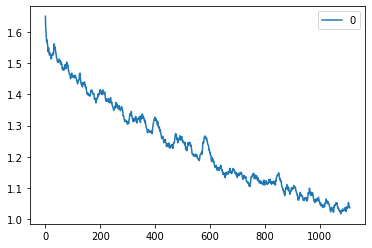

In [ ]:
df = pd.DataFrame(train_losses[1000:])
ema_loss= df.ewm(alpha=0.1).mean()
ema_loss.plot()

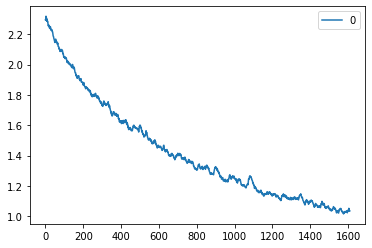

In [ ]:
df = pd.DataFrame(train_losses[500:])
ema_loss= df.ewm(alpha=0.1).mean()
ema_loss.plot()

In [ ]:
x_batch = x_noisy.cuda()

In [ ]:
%%time
# model.cpu()
model.eval()
with torch.no_grad():
  scores = model(x_batch, torch.zeros(x_batch.shape[0], device=x_batch.device)).cpu()
scores.shape

CPU times: user 79.3 ms, sys: 4.87 ms, total: 84.2 ms
Wall time: 84 ms


torch.Size([1000, 3, 8, 8])

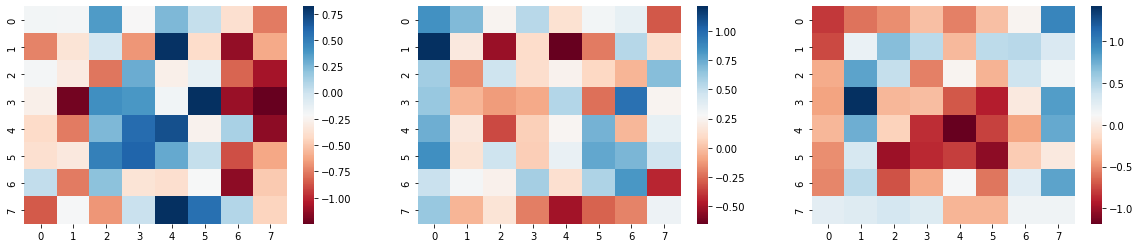

In [ ]:
score_mean = scores.mean(0)
fig, axs = plt.subplots(1,N_CATEGORIES, figsize=(20,4))
for i in range(N_CATEGORIES):
  sns.heatmap(score_mean[i], ax=axs[i], cmap="RdBu")

In [ ]:
x_rec = x_noisy + (scores * 2e-2)
x_rec_mean = x_rec.mean(0)
x_rec_probs = x_rec_mean.softmax(0)

anal_x_rec = x_noisy + (x_grad * 2e-2)
anal_x_rec_probs = anal_x_rec.mean(0).softmax(0)
x_rec_mean.shape, x_noisy_mean.shape, x_rec_probs.shape

(torch.Size([3, 8, 8]), torch.Size([3, 8, 8]), torch.Size([3, 8, 8]))

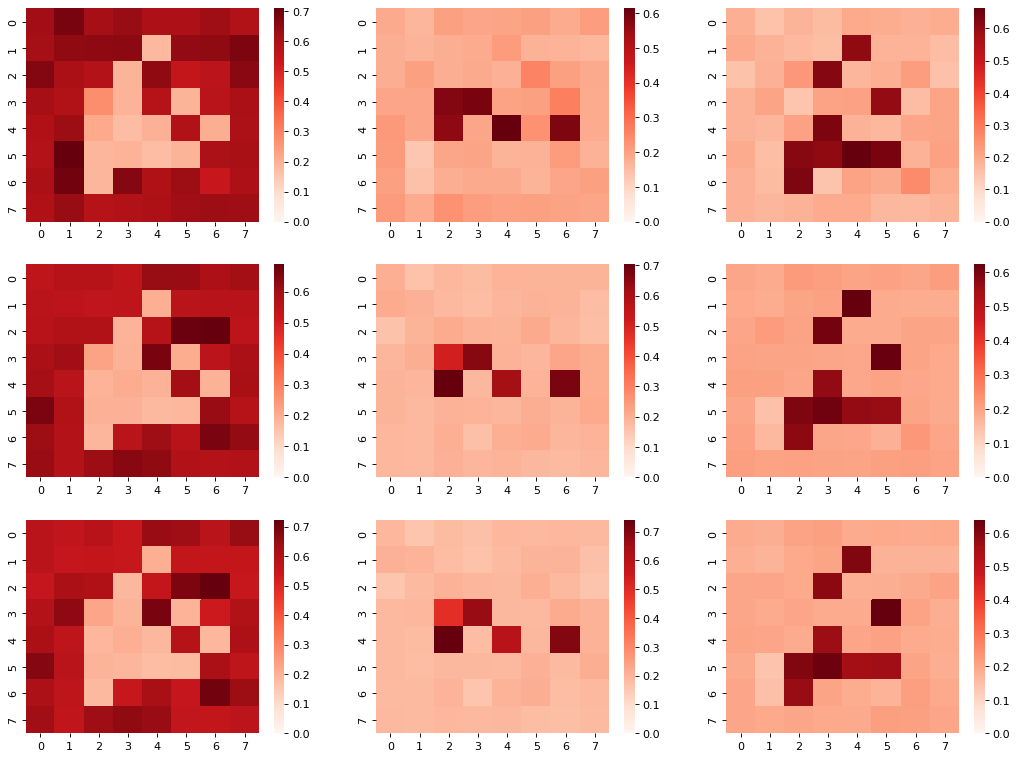

In [ ]:
idx=3
fig, axs = plt.subplots(3, N_CATEGORIES, figsize=(16,12), dpi=80)
for i in range(N_CATEGORIES):
  sns.heatmap(x_noisy[idx].exp()[i], ax=axs[0,i], vmin=0.0, vmax=None, cmap="Reds")
  sns.heatmap(x_rec[idx].exp()[i], ax=axs[1,i], vmin=0.0, cmap="Reds")
  sns.heatmap(anal_x_rec[idx].exp()[i], ax=axs[2,i], vmin=0.0, vmax=None, cmap="Reds")

In [ ]:
torch.sum((x_rec[idx] - anal_x_rec[idx])**2)

tensor(0.1443)

In [ ]:
print(torch.logsumexp(x_logit, dim=1).mean())

tensor(2.0027e-05)


> ### If I subtract LSE everytime, then I am "removing" more than I am updating via score
> ### so it will prolly nullify all my score climbing

In [ ]:
model.eval()
with torch.no_grad():
  x_denoised = x_noisy[:1].clone().cuda()
  for i in range(20):
    # print(torch.logsumexp(x_denoised, dim=1).mean())
    s = model(x_denoised, torch.zeros(1,device="cuda"))
    x_denoised = x_denoised + s * 1e-2

    # Small hack to normalize logits back to conform with
    # concrete distribution as it expects LSE to be zero ideally
    if torch.logsumexp(x_denoised, dim=1).mean().abs() > 1e-5:
      x_denoised -= torch.logsumexp(x_denoised, dim=1)

x_denoised.shape

torch.Size([1, 3, 8, 8])

In [ ]:
torch.linalg.norm(s * 1e-2), torch.logsumexp(x_noisy[:1], dim=1).norm()

(tensor(0.0129, device='cuda:0'), tensor(2.5810e-07))

In [ ]:
torch.logsumexp(x_denoised, dim=1).mean()

tensor(1.3970e-09, device='cuda:0')

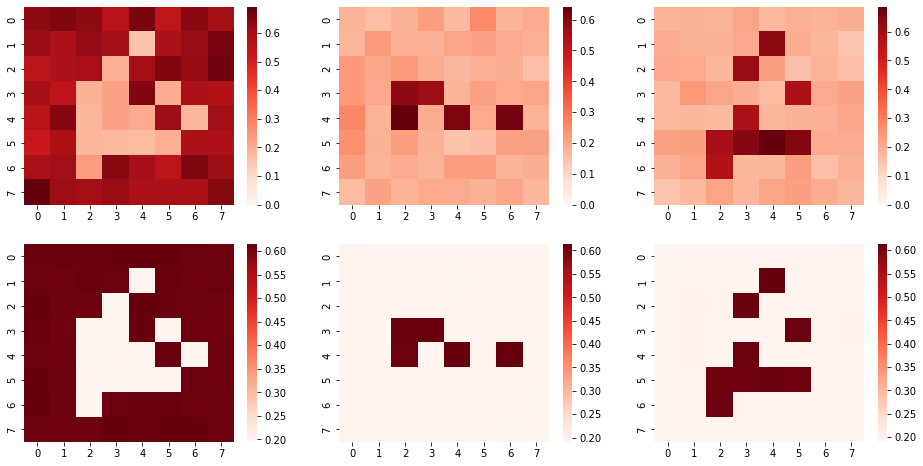

In [ ]:
fig, axs = plt.subplots(2, N_CATEGORIES, figsize=(16,8))
for i in range(N_CATEGORIES):
  sns.heatmap(x_noisy[0].exp()[i], ax=axs[0,i], vmin=0.0, vmax=None, cmap="Reds")
  sns.heatmap(x_denoised[0,i].exp().cpu(), ax=axs[1,i], cmap="Reds")